# Patch Testing
We will test the `PatchState` and `PatchModel` classes.

## Initial setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import treadmillio.taskstatemachine as tsm

## PatchModel

### ExponentialPatch

In [2]:
# Patch settings
patch_type = 'Exponential'
tau = 10.0
r0 = 2.0
t_start = 0.0
t_stop = 100.0

# Expected behavior
f = lambda t: r0*np.exp(-t/tau)
F = lambda t: r0*tau*(1.0 - np.exp(-t/tau))

# Initialize patch
params = {'tau': tau,
          'r0': r0}
patch = tsm.ExponentialPatch(patch_type,
                             params,
                             init_time=t_start,
                             time_base='seconds')

#### Single patch

In [3]:
# Generate reward values
tt = np.linspace(t_start, t_stop, 1000)
R = np.zeros(len(tt))
for i, t in enumerate(tt):
    patch.update(t)
    R[i] = patch.available_reward

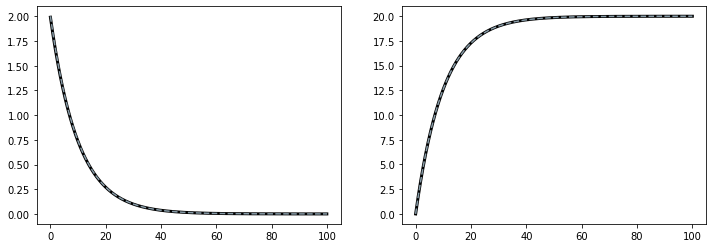

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
cmap = plt.get_cmap('bone')

ax[0].plot(tt[:-1], np.diff(R)/(tt[1]-tt[0]), color=cmap(0.0), linewidth=3.0)
ax[0].plot(tt, f(tt), color=cmap(0.6), linestyle='--')
ax[1].plot(tt, R, color=cmap(0.0), linewidth=3.0)
ax[1].plot(tt, F(tt), color=cmap(0.6), linestyle='--')

#### Multiple patches

In [5]:
num_patches = 1000
R = np.zeros([num_patches, len(tt)])
for i in range(num_patches):
    for j, t in enumerate(tt):
        patch.update(t)
        R[i, j] = patch.available_reward
    patch.reset()

In [6]:
# Check for determinism
print((np.sum(np.isclose(R[0, :][np.newaxis, :], R), axis=0) == R.shape[0]).all())

True


### PoissonPatch

In [7]:
# Patch settings
patch_type = 'Poisson'
tau = 10.0
V0 = 0.75
lambda0 = 4.0
t_start = 0.0
t_stop = 100.0

# Expected behavior
f_N = lambda t:    lambda0*np.exp(-t/tau)
F_N = lambda t, s: lambda0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau))
f_R = lambda t:    V0*f_N(t)
F_R = lambda t, s: V0*F_N(t, s)

# Initialize patch
params = {'tau': tau,
          'V0': V0,
          'lambda0': lambda0}
patch = tsm.PoissonPatch(patch_type,
                         params,
                         init_time=t_start,
                         time_base='seconds')

#### Single patch

In [8]:
tt = np.linspace(t_start, t_stop, 1000)
R = np.zeros(len(tt))
for i, t in enumerate(tt):
    patch.update(t)
    R[i] = patch.available_reward
    
T = patch.t_drip
N = len(T)

Expected number of drips: 40.00
Actual number of drips:   40


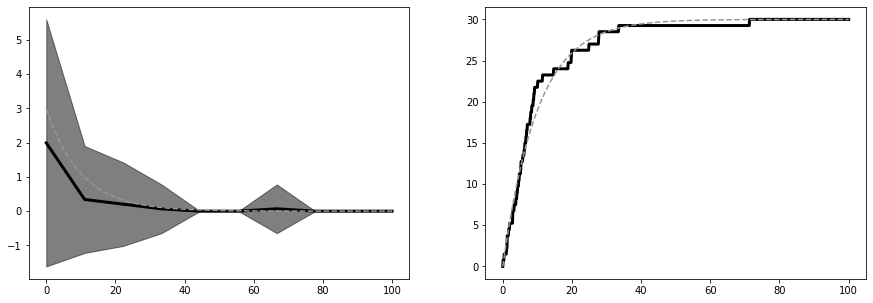

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Calculate reward rate over time
dt = tt[1] - tt[0]
t_diff = np.linspace(t_start, t_stop, num=10) # time bins
R_diff = np.zeros([2, len(t_diff)])
for i in range(len(t_diff)-1):
    idx = np.logical_and(tt > t_diff[i], tt < t_diff[i+1])
    R_diff[0, i] = np.mean(np.diff(R[idx])/dt)
    R_diff[1, i] = np.std(np.diff(R[idx])/dt)

# Plot average vs. expected reward rate
ax[0].plot(t_diff, R_diff[0, :], color=cmap(0.0), linewidth=3.0)
ax[0].fill_between(t_diff, 
                   y1=R_diff[0, :]-R_diff[1, :], 
                   y2=R_diff[0, :]+R_diff[1, :],
                   color=cmap(0.0),
                   alpha=0.5)
ax[0].plot(tt, f_R(tt), color=cmap(0.6), linestyle='--')

# Plot actual vs. expected reward
ax[1].plot(tt, R, color=cmap(0.0), linewidth=3.0)
ax[1].plot(tt, F_R(np.ones(len(tt))*t_start, tt), color=cmap(0.6), linestyle='--')

print('Expected number of drips: {:.2f}'.format(patch._Lam(t_start, t_stop-t_start)))
print('Actual number of drips:   {}'.format(N))

#### Multiple patches

In [10]:
# Settings
num_patches = 1000

# Placeholders
tt = np.linspace(t_start, t_stop, 1000)
R = np.zeros([num_patches, len(tt)])
N = np.zeros([num_patches])

# Simulate patches
for i in range(num_patches):
    for j, t in enumerate(tt):
        patch.update(t)
        R[i, j] = patch.available_reward 
    N[i] = len(patch.t_drip)
    patch.reset()

Expected number of drips: 40.00 +/- 6.32
Actual number of drips:   40.07 +/- 6.48


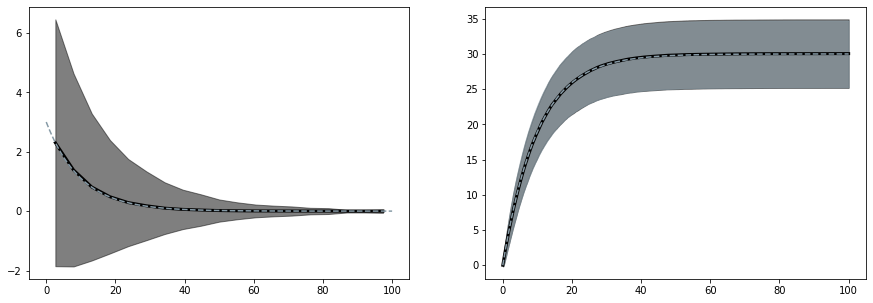

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Calculate reward rate over time
dt = tt[1] - tt[0]
t_diff = np.linspace(t_start, t_stop, num=20) # time bins
R_diff = np.zeros([2, len(t_diff)-1])
for i in range(len(t_diff)-1):
    idx = np.logical_and(tt > t_diff[i], tt < t_diff[i+1])
    R_diff[0, i] = np.mean(np.diff(R[:, idx])/dt)
    R_diff[1, i] = np.std(np.diff(R[:, idx])/dt)

# Plot average vs. expected reward rate
t_bin = t_diff[:-1]+0.5*(t_diff[1]-t_diff[0])
ax[0].plot(t_bin, 
           R_diff[0, :], 
           color=cmap(0.0), 
           linewidth=3.0)
ax[0].fill_between(t_bin, 
                   y1=R_diff[0, :]-R_diff[1, :], 
                   y2=R_diff[0, :]+R_diff[1, :],
                   color=cmap(0.0),
                   alpha=0.5)
ax[0].plot(tt, f_R(tt), color=cmap(0.6), linestyle='--')

# Plot actual vs. expected reward
R_mean = np.mean(R, axis=0)
R_std = np.std(R, axis=0)
ax[1].plot(tt, R_mean, color=cmap(0.0), linewidth=3.0)
ax[1].fill_between(tt,
                   y1=R_mean-R_std,
                   y2=R_mean+R_std,
                   color=cmap(0.0),
                   alpha=0.5)
F_R_std = V0*F_N(np.ones(len(tt))*t_start, tt-t_start)**0.5 # remember, variance scales as k^2!
ax[1].plot(tt, 
           F_R(np.ones(len(tt))*t_start, tt-t_start), 
           color=cmap(0.6), 
           linestyle='--')
ax[1].fill_between(tt, 
                   y1=F_R(np.ones(len(tt))*t_start, tt-t_start)-F_R_std,
                   y2=F_R(np.ones(len(tt))*t_start, tt-t_start)+F_R_std,
                   color=cmap(0.6), 
                   alpha=0.5)

E_N = patch._Lam(t_start, t_stop-t_start)
print('Expected number of drips: {:.2f} +/- {:.2f}'.format(E_N, E_N**0.5))
print('Actual number of drips:   {:.2f} +/- {:.2f}'.format(np.mean(N), np.std(N)))

#### Variance tuning
Once nice feature of the Poisson model is the ability to manipulate the model stochasticity (i.e. variance) independently from the expectation. Given some exponential (deterministic) model with an instantaneous reward rate given by:

$
\quad r(t) = r_0 e^{-\frac{t}{\tau}}
$

a Poisson model with the same expectation can be created by constraining its parameters such that:

$
\quad \tau = \tau_{exp} = \tau_{Poisson} \\
\quad V_0 = \dfrac{\sigma^2_V}{r_0 \tau} \\
\quad \lambda_0 = \dfrac{r^2_0 \tau}{\sigma^2_V}
$

where $\sigma^2_V$ is the desired variance in total cumulative reward volume (as $t \rightarrow \infty$).

In [12]:
# Patch settings
patch_type = 'Poisson'
var = 16.0 # desired reward variance over infinite patch

# Exponential constraints
tau = 10.0 # decay rate
r0 = 2.0 # initial rate

# Poisson parameters
V0 = var/(tau*r0)
lambda0 = (tau*r0**2)/var
t_start = 0.0
t_stop = 10*tau # sufficiently long to approach reward limit

# Expected behavior
f_N = lambda t:    lambda0*np.exp(-t/tau)
F_N = lambda t, s: lambda0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau))
f_R = lambda t:    V0*f_N(t)
F_R = lambda t, s: V0*F_N(t, s)

# Initialize patch
params = {'tau': tau,
          'V0': V0,
          'lambda0': lambda0}
patch = tsm.PoissonPatch(patch_type,
                         params,
                         init_time=t_start,
                         time_base='seconds')

In [13]:
# Settings
num_patches = 1000

# Placeholders
tt = np.linspace(t_start, t_stop, 1000)
R = np.zeros([num_patches, len(tt)])
N = np.zeros([num_patches])

# Simulate patches
for i in range(num_patches):
    for j, t in enumerate(tt):
        patch.update(t)
        R[i, j] = patch.available_reward 
    N[i] = len(patch.t_drip)
    patch.reset()

Desired std: 4.00
Expected volume: 20.00 +/- 4.00
Actual volume:   20.02 +/- 3.87


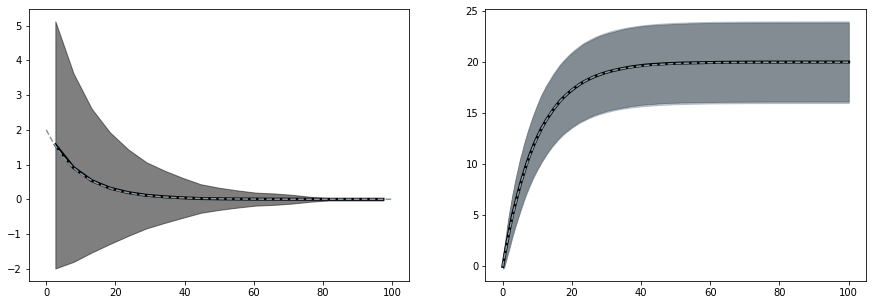

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Calculate reward rate over time
dt = tt[1] - tt[0]
t_diff = np.linspace(t_start, t_stop, num=20) # time bins
R_diff = np.zeros([2, len(t_diff)-1])
for i in range(len(t_diff)-1):
    idx = np.logical_and(tt > t_diff[i], tt < t_diff[i+1])
    R_diff[0, i] = np.mean(np.diff(R[:, idx])/dt)
    R_diff[1, i] = np.std(np.diff(R[:, idx])/dt)

# Plot average vs. expected reward rate
t_bin = t_diff[:-1]+0.5*(t_diff[1]-t_diff[0])
ax[0].plot(t_bin, 
           R_diff[0, :], 
           color=cmap(0.0), 
           linewidth=3.0)
ax[0].fill_between(t_bin, 
                   y1=R_diff[0, :]-R_diff[1, :], 
                   y2=R_diff[0, :]+R_diff[1, :],
                   color=cmap(0.0),
                   alpha=0.5)
ax[0].plot(tt, f_R(tt), color=cmap(0.6), linestyle='--')

# Plot actual vs. expected reward
R_mean = np.mean(R, axis=0)
R_std = np.std(R, axis=0)
ax[1].plot(tt, R_mean, color=cmap(0.0), linewidth=3.0)
ax[1].fill_between(tt,
                   y1=R_mean-R_std,
                   y2=R_mean+R_std,
                   color=cmap(0.0),
                   alpha=0.5)
F_R_std = V0*F_N(np.ones(len(tt))*t_start, tt-t_start)**0.5 # remember, variance scales as k^2!
ax[1].plot(tt, 
           F_R(np.ones(len(tt))*t_start, tt-t_start), 
           color=cmap(0.6), 
           linestyle='--')
ax[1].fill_between(tt, 
                   y1=F_R(np.ones(len(tt))*t_start, tt-t_start)-F_R_std,
                   y2=F_R(np.ones(len(tt))*t_start, tt-t_start)+F_R_std,
                   color=cmap(0.6), 
                   alpha=0.5)

E_N = patch._Lam(t_start, t_stop-t_start)
print('Desired std: {:.2f}'.format(var**0.5))
print('Expected volume: {:.2f} +/- {:.2f}'.format(V0*E_N, V0*E_N**0.5))
print('Actual volume:   {:.2f} +/- {:.2f}'.format(np.mean(V0*N), np.std(V0*N)))

## PatchState

In [19]:
import copy
import math
import yaml
from treadmillio.taskstatemachine import TaskStateMachine

In [20]:
class DummyInterface:
    
    def __init__(self, dt, t_start=0.0):
        self.MasterTime = t_start
        self.dt = dt
        
    def update(self):
        self.MasterTime += dt

### ExponentialPatch

In [21]:
param_file = '../ExampleConfigFiles/patch_exponential.yaml'
with open(param_file, 'r') as f:
    config = yaml.safe_load(f)

In [22]:
dt = 2.0 # ms
Interface = DummyInterface(dt, t_start=0.0)
StateMachine = TaskStateMachine(config['StateMachine'], Interface, None)

{'FirstState': True, 'Type': 'Delay', 'Params': {'Duration': 'Fixed', 'Value': 10}, 'NextState': 'InPatch-Enter'}
{'Type': 'Patch', 'Params': {'ModelType': 'Exponential', 'ModelParams': {'tau': {'Distribution': 'Uniform', 'Low': 10.0, 'High': 15.0}, 'r0': {'Distribution': 'Uniform', 'Low': 0.5, 'High': 2.0}}, 'SwitchRate': 0.05}, 'NextState': {'InPatch-Waiting': {'ConditionType': 'None', 'Priority': 0}, 'InPatch-Reward': {'ConditionType': 'Reward', 'Value': 2.0, 'Priority': 1}, 'Interpatch': {'ConditionType': 'ElapsedTime', 'Duration': 10000, 'Priority': 2}}}
{'Type': 'Delay', 'Params': {'Duration': 'Fixed', 'Value': 1}, 'NextState': 'InPatch-Update'}
{'Type': 'SetInternalState', 'Params': {'State': 'InPatch-Waiting', 'InternalState': 'NewPatch', 'Value': True}, 'NextState': 'InPatch-Waiting'}
{'Type': 'SetInternalState', 'Params': {'State': 'InPatch-Waiting', 'InternalState': 'RewardHarvest', 'Value': 2.0}, 'NextState': 'InPatch-Waiting'}
First state is Interpatch


../treadmillio/taskstatemachine.py:820: RuntimeWarning: StateMachine being created without sound (no SoundController specified).
  RuntimeWarning)


In [23]:
# Get patch objects
patch = StateMachine.StateMachineDict['InPatch-Waiting']

In [24]:
# Settings
duration = 10000.0 # seconds
print_updates = False

# Placeholders
params = [] # parameters for each PatchState
R_model = [] # list of rewards per model
R = [] # available reward for each time step
R_ = []

StartTime = Interface.MasterTime
EndTime = StartTime + duration*1000
while (Interface.MasterTime < EndTime):
    # Cache patch parameters
    cache = copy.copy(patch.Model.params)
    
    # Updates
    Interface.update() # update dummy time
    StateMachine.update_statemachine() # update the state machine
    label = StateMachine.CurrentState.label
    
    # Print reward updates
    if print_updates and ('Reward' in label) and StateMachine.new_state:
        print('Reward at time {}.'.format((Interface.MasterTime-StartTime)/1000))
    
    # Print patch updates
    if label == patch.label:
        if not patch.NewPatch:
            R_.append([patch.Model.t, patch.Model.available_reward])
        elif len(R_) > 0:
            R.append(np.array(R_))
            R_ = []
            if print_updates:
                print('New exponential patch at time {}.'.format((Interface.MasterTime-StartTime)/1000))
        if any([p_old != p_new for (_, p_old), (_, p_new) in zip(cache.items(), patch.Model.params.items())]):
            if len(R) > 0:
                params.append(cache)
                R_model.append(R)
                R = []
                if print_updates:
                    print('Exponential patch changed to parameters:')
                    for name, value in patch.Model.params.items():
                        print('{}: {:.2f}'.format(name, value))

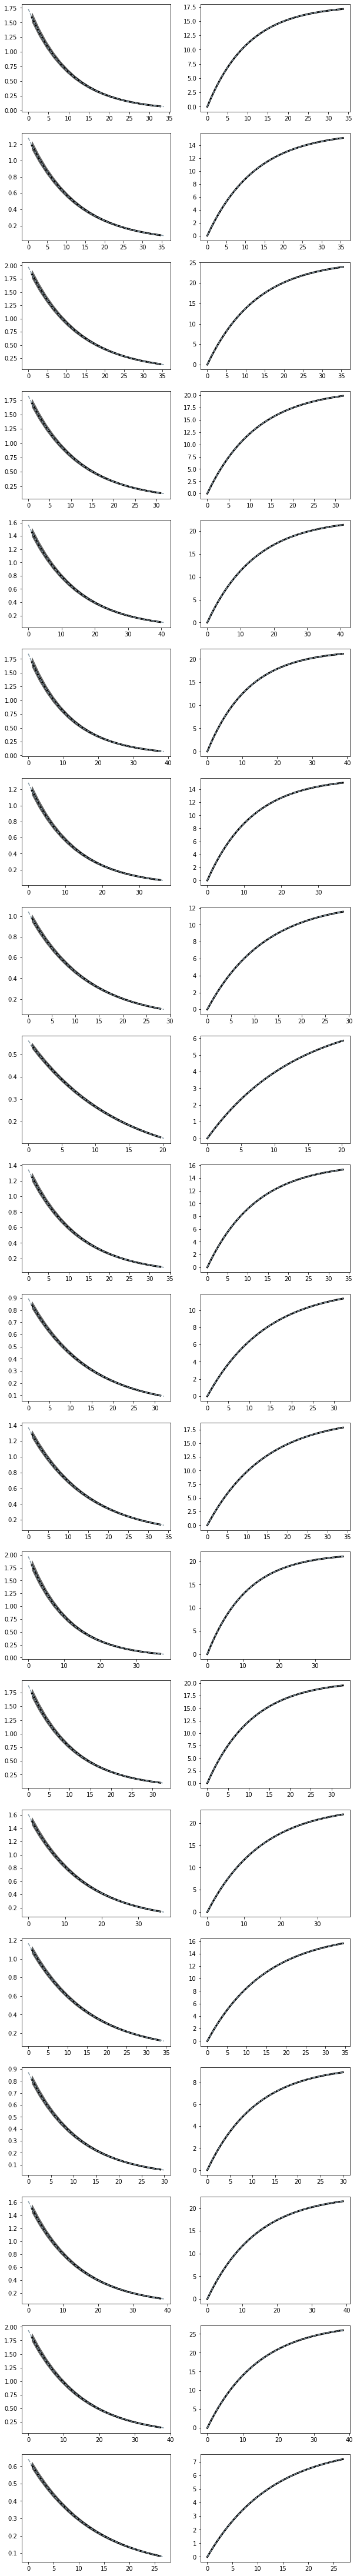

In [25]:
fig, ax = plt.subplots(len(R_model), 2, figsize=(10, 4*len(R_model)))

# Compare each set of model parameters
n_patch = 0
for i, (p, r) in enumerate(zip(params, R_model)):
    # Accumulate total number of patches
    n_patch += len(r)
    
    # Find minimum patch length in set
    t_min = math.inf
    for r_ in r:
        if r_[-1, 0] < t_min:
            t_min = r_[-1, 0]

    # Create interpolated array of reward vs. time data
    R = np.zeros([len(r), 1000])
    tt = np.linspace(0.0, t_min, 1000)
    for j, r_ in enumerate(r):
        # Linear interpolation should be fine given fine time scale
        R[j, :] = np.interp(tt, r_[:, 0], r_[:, 1])

    # Calculate reward rate over time
    dt = tt[1] - tt[0]
    t_diff = np.linspace(0.0, t_min, num=20) # time bins
    R_diff = np.zeros([2, len(t_diff)-1])
    for j in range(len(t_diff)-1):
        idx = np.logical_and(tt > t_diff[j], tt < t_diff[j+1])
        R_diff[0, j] = np.mean(np.diff(R[:, idx])/dt)
        R_diff[1, j] = np.std(np.diff(R[:, idx])/dt)

    # Expected behavior
    r0 = p['r0']
    tau = p['tau']
    f_R = lambda t: r0*np.exp(-t/tau)
    F_R = lambda t: r0*tau*(1.0 - np.exp(-t/tau))
        
    # Plot average vs. expected reward rate
    t_bin = t_diff[:-1]+0.5*(t_diff[1]-t_diff[0])
    ax[i, 0].plot(t_bin, 
               R_diff[0, :], 
               color=cmap(0.0), 
               linewidth=3.0)
    ax[i, 0].fill_between(t_bin, 
                       y1=R_diff[0, :]-R_diff[1, :], 
                       y2=R_diff[0, :]+R_diff[1, :],
                       color=cmap(0.0),
                       alpha=0.5)
    ax[i, 0].plot(tt, f_R(tt), color=cmap(0.6), linestyle='--')

    # Plot actual vs. expected reward
    R_mean = np.mean(R, axis=0)
    R_std = np.std(R, axis=0)
    ax[i, 1].plot(tt, R_mean, color=cmap(0.0), linewidth=3.0)
    ax[i, 1].fill_between(tt,
                       y1=R_mean-R_std,
                       y2=R_mean+R_std,
                       color=cmap(0.0),
                       alpha=0.5)
    ax[i, 1].plot(tt, 
               F_R(tt), 
               color=cmap(0.6), 
               linestyle='--')

In [26]:
# Check parameter reset
print('Expected reset rate: {:.3f}'.format(patch.Model.p_switch))
print('Actual reset rate:   {:.3f}'.format(len(R_model)/n_patch))

Expected reset rate: 0.050
Actual reset rate:   0.072


### PoissonPatch

In [27]:
param_file = '../ExampleConfigFiles/patch_poisson.yaml'
with open(param_file, 'r') as f:
    config = yaml.safe_load(f)

In [28]:
dt = 2.0 # ms
Interface = DummyInterface(dt, t_start=0.0)
StateMachine = TaskStateMachine(config['StateMachine'], Interface, None)

{'FirstState': True, 'Type': 'Delay', 'Params': {'Duration': 'Fixed', 'Value': 10}, 'NextState': 'InPatch-Enter'}
{'Type': 'Patch', 'Params': {'ModelType': 'Poisson', 'ModelParams': {'tau': {'Distribution': 'Uniform', 'Low': 10.0, 'High': 15.0}, 'V0': 0.5, 'lambda0': {'Distribution': 'LogUniform', 'Low': 0.5, 'High': 5.0}}, 'SwitchRate': 0.05}, 'NextState': {'InPatch-Waiting': {'ConditionType': 'None', 'Priority': 0}, 'InPatch-Reward': {'ConditionType': 'Reward', 'Value': 2.0, 'Priority': 1}, 'Interpatch': {'ConditionType': 'ElapsedTime', 'Duration': 10000, 'Priority': 2}}}
{'Type': 'Delay', 'Params': {'Duration': 'Fixed', 'Value': 1}, 'NextState': 'InPatch-Update'}
{'Type': 'SetInternalState', 'Params': {'State': 'InPatch-Waiting', 'InternalState': 'NewPatch', 'Value': True}, 'NextState': 'InPatch-Waiting'}
{'Type': 'SetInternalState', 'Params': {'State': 'InPatch-Waiting', 'InternalState': 'RewardHarvest', 'Value': 2.0}, 'NextState': 'InPatch-Waiting'}
First state is Interpatch


In [29]:
# Get patch objects
patch = StateMachine.StateMachineDict['InPatch-Waiting']

In [30]:
# Settings
duration = 10000.0 # seconds
print_updates = False

# Placeholders
params = [] # parameters for each PatchState
R_model = [] # list of rewards per model
R = [] # available reward for each time step
R_ = []

StartTime = Interface.MasterTime
EndTime = StartTime + duration*1000
while (Interface.MasterTime < EndTime):
    # Cache patch parameters
    cache = copy.copy(patch.Model.params)
    
    # Updates
    Interface.update() # update dummy time
    StateMachine.update_statemachine() # update the state machine
    label = StateMachine.CurrentState.label
    
    # Print reward updates
    if print_updates and ('Reward' in label) and StateMachine.new_state:
        print('Reward at time {}.'.format((Interface.MasterTime-StartTime)/1000))
    
    # Print patch updates
    if label == patch.label:
        if not patch.NewPatch:
            R_.append([patch.Model.t, patch.Model.available_reward])
        elif len(R_) > 0:
            R.append(np.array(R_))
            R_ = []
            if print_updates:
                print('New Poisson patch at time {}.'.format((Interface.MasterTime-StartTime)/1000))
        if any([p_old != p_new for (_, p_old), (_, p_new) in zip(cache.items(), patch.Model.params.items())]):
            if len(R) > 0:
                params.append(cache)
                R_model.append(R)
                R = []
                if print_updates:
                    print('Poisson patch changed to parameters:')
                    for name, value in patch.Model.params.items():
                        print('{}: {:.2f}'.format(name, value))

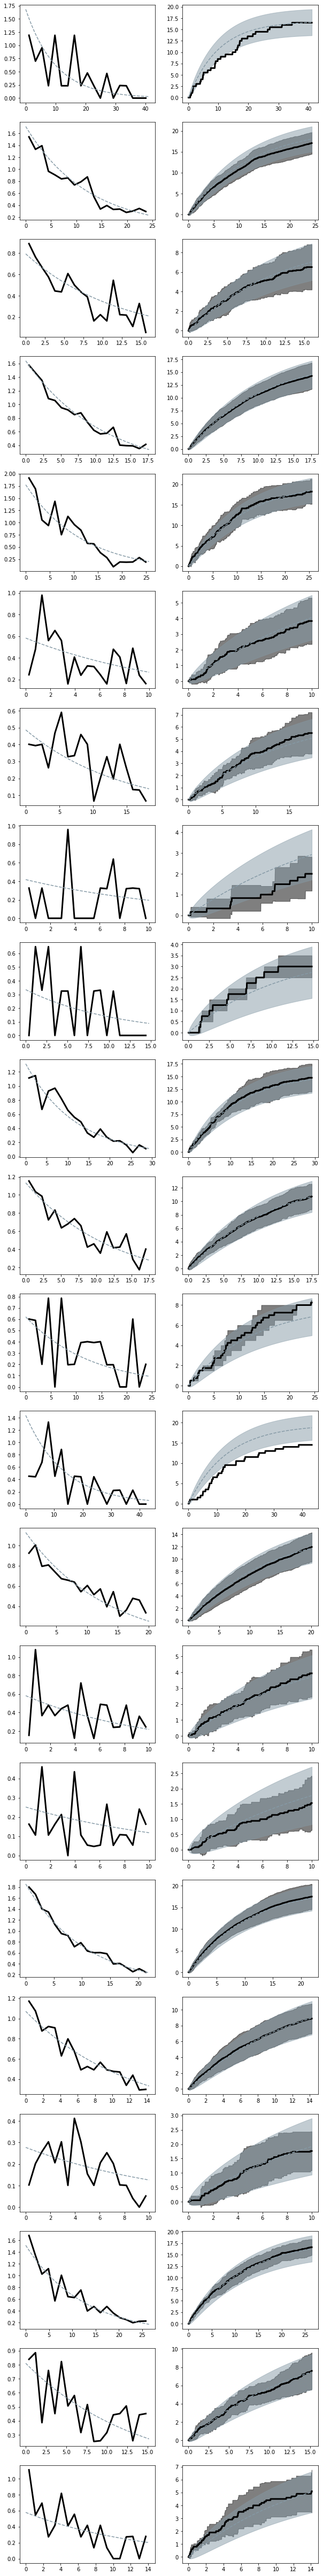

In [31]:
fig, ax = plt.subplots(len(R_model), 2, figsize=(10, 4*len(R_model)))

# Compare each set of model parameters
for i, (p, r) in enumerate(zip(params, R_model)):
    # Find minimum patch length in set
    t_min = math.inf
    for r_ in r:
        if r_[-1, 0] < t_min:
            t_min = r_[-1, 0]

    # Create interpolated array of reward vs. time data
    R = np.zeros([len(r), 1000])
    tt = np.linspace(0.0, t_min, 1000)
    for j, r_ in enumerate(r):
        # Linear interpolation should be fine given fine time scale
        R[j, :] = np.interp(tt, r_[:, 0], r_[:, 1])

    # Calculate reward rate over time
    dt = tt[1] - tt[0]
    t_diff = np.linspace(0.0, t_min, num=20) # time bins
    R_diff = np.zeros([2, len(t_diff)-1])
    for j in range(len(t_diff)-1):
        idx = np.logical_and(tt > t_diff[j], tt < t_diff[j+1])
        R_diff[0, j] = np.mean(np.diff(R[:, idx])/dt)
        R_diff[1, j] = np.std(np.diff(R[:, idx])/dt)

    # Expected behavior
    tau = p['tau']
    lambda0 = p['lambda0']
    V0 = p['V0']
    f_N = lambda t:    lambda0*np.exp(-t/tau)
    F_N = lambda t, s: lambda0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau))
    f_R = lambda t:    V0*f_N(t)
    F_R = lambda t, s: V0*F_N(t, s)
        
    # Plot average vs. expected reward rate
    t_bin = t_diff[:-1]+0.5*(t_diff[1]-t_diff[0])
    ax[i, 0].plot(t_bin, 
               R_diff[0, :], 
               color=cmap(0.0), 
               linewidth=3.0)
    ax[i, 0].plot(tt, f_R(tt), color=cmap(0.6), linestyle='--')

    # Plot actual vs. expected reward
    R_mean = np.mean(R, axis=0)
    R_std = np.std(R, axis=0)
    ax[i, 1].plot(tt, R_mean, color=cmap(0.0), linewidth=3.0)
    ax[i, 1].fill_between(tt,
                       y1=R_mean-R_std,
                       y2=R_mean+R_std,
                       color=cmap(0.0),
                       alpha=0.5)
    F_R_std = V0*F_N(np.ones(len(tt))*t_start, tt-t_start)**0.5 # remember, variance scales as k^2!
    ax[i, 1].plot(tt, 
               F_R(np.ones(len(tt))*t_start, tt-t_start), 
               color=cmap(0.6), 
               linestyle='--')
    ax[i, 1].fill_between(tt, 
                       y1=F_R(np.ones(len(tt))*t_start, tt-t_start)-F_R_std,
                       y2=F_R(np.ones(len(tt))*t_start, tt-t_start)+F_R_std,
                       color=cmap(0.6), 
                       alpha=0.5)

In [32]:
# Check parameter reset
print('Expected reset rate: {:.3f}'.format(patch.Model.p_switch))
print('Actual reset rate:   {:.3f}'.format(len(R_model)/n_patch))

Expected reset rate: 0.050
Actual reset rate:   0.079
